In [ ]:
!pip install kagglehub xgboost shap --quiet

Importing the libraries

In [ ]:
import kagglehub, os, warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, ConfusionMatrixDisplay, roc_curve
)
warnings.filterwarnings("ignore")


Loading the DATA

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'telco-customer-churn' dataset.
Path to dataset files: /kaggle/input/telco-customer-churn


In [ ]:
file_path = os.path.join(path, "WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [ ]:
df = pd.read_csv(file_path)
print("Dataset downloaded and loaded successfully!")
print("Shape:", df.shape)
display(df.head())

Dataset downloaded and loaded successfully!
Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Cleaning the data

In [ ]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)
df.drop(["customerID"], axis=1, inplace=True)
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

Feature Encoding

In [ ]:
cat_cols = df.select_dtypes(include="object").columns
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

TRAIN/TEST SPLIT & SCALING

In [ ]:
X = df.drop("Churn", axis=1)
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Training the model


In [ ]:
log_reg = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(n_estimators=200, random_state=42)
xgb = XGBClassifier(eval_metric='logloss', random_state=42)

models = {"Logistic Regression": log_reg, "Random Forest": rf, "XGBoost": xgb}
for name, model in models.items():
    model.fit(X_train, y_train)
print("All models trained successfully!")

All models trained successfully!


Evaluating the model


Logistic Regression
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1035
           1       0.64      0.55      0.59       374

    accuracy                           0.80      1409
   macro avg       0.74      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409



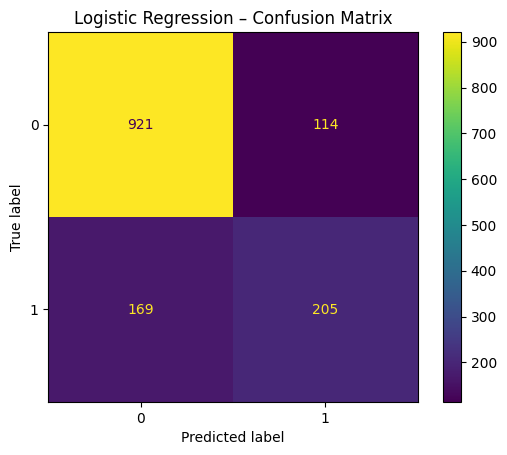


Random Forest
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.63      0.49      0.55       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409



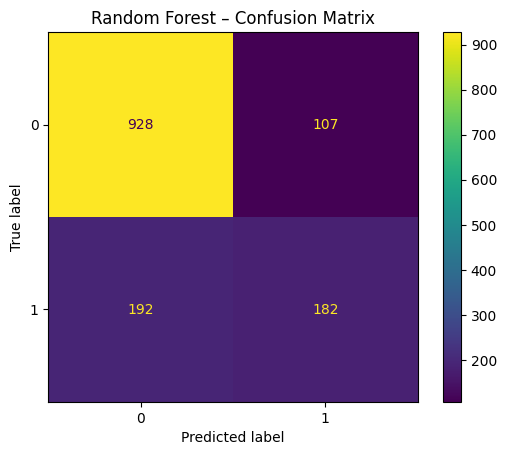


XGBoost
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1035
           1       0.60      0.52      0.55       374

    accuracy                           0.78      1409
   macro avg       0.71      0.69      0.70      1409
weighted avg       0.77      0.78      0.77      1409



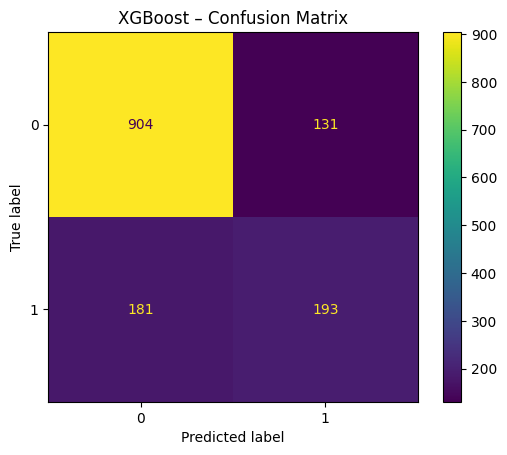


 MODEL PERFORMANCE COMPARISON


,Model,Accuracy,ROC_AUC
0,Logistic Regression,0.799148,0.840280
1,Random Forest,0.787793,0.824679
2,XGBoost,0.778566,0.818540


In [ ]:
results = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    acc = model.score(X_test, y_test)
    auc = roc_auc_score(y_test, y_prob)
    results.append([name, acc, auc])

    print(f"\n{name}")
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    plt.title(f"{name} – Confusion Matrix")
    plt.show()

results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "ROC_AUC"])
print("\n MODEL PERFORMANCE COMPARISON")
display(results_df.sort_values(by="ROC_AUC", ascending=False))

Feature Importance (XGboost)

<Figure size 800x500 with 0 Axes>

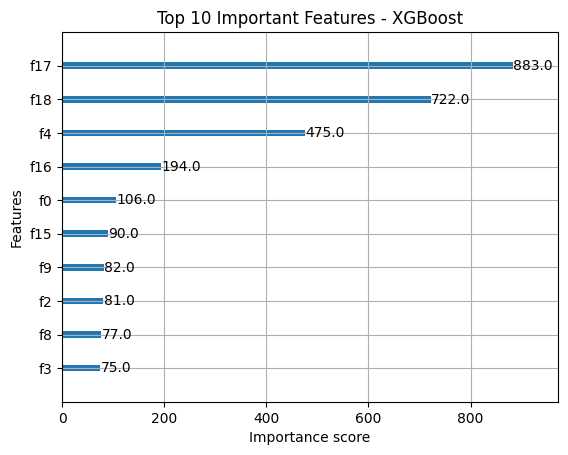

In [ ]:
plt.figure(figsize=(8,5))
plot_importance(xgb, max_num_features=10)
plt.title("Top 10 Important Features - XGBoost")
plt.show()

Churn probabilities

In [ ]:
y_pred_proba = xgb.predict_proba(X_test)[:, 1]
pred_results = pd.DataFrame({
    "Customer_Index": y_test.index,
    "Actual_Churn": y_test.values,
    "Churn_Probability": y_pred_proba
}).sort_values(by="Churn_Probability", ascending=False)

pred_results.to_csv("churn_predictions.csv", index=False)
print(" churn_predictions.csv exported successfully!")

 churn_predictions.csv exported successfully!


ROC Curve

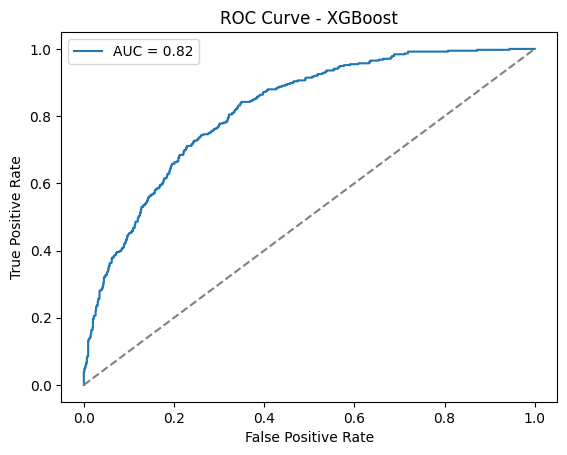

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_pred_proba):.2f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend()
plt.show()

Summary

In [ ]:
best_model = results_df.sort_values(by="ROC_AUC", ascending=False).iloc[0]
print(f"\n Best Model: {best_model['Model']} (ROC_AUC: {best_model['ROC_AUC']:.3f})")


 Best Model: Logistic Regression (ROC_AUC: 0.840)


Saving the best model

In [ ]:
import pickle
pickle.dump(xgb, open("churn_xgb_model.pkl", "wb"))
print(" Model saved as churn_xgb_model.pkl")

 Model saved as churn_xgb_model.pkl


Churn Insights & Visualizations

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
df_viz = pd.read_csv(file_path)
df_viz["Churn"] = df_viz["Churn"].map({"Yes": 1, "No": 0})

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("deep")

CHURN RATE OVERVIEW

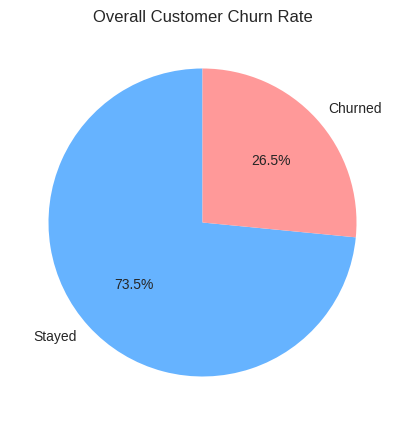

In [ ]:
plt.figure(figsize=(5,5))
labels = ["Stayed", "Churned"]
sizes = [df_viz["Churn"].value_counts()[0], df_viz["Churn"].value_counts()[1]]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=["#66b3ff","#ff9999"])
plt.title("Overall Customer Churn Rate")
plt.show()

CHURN BY CONTRACT TYPE

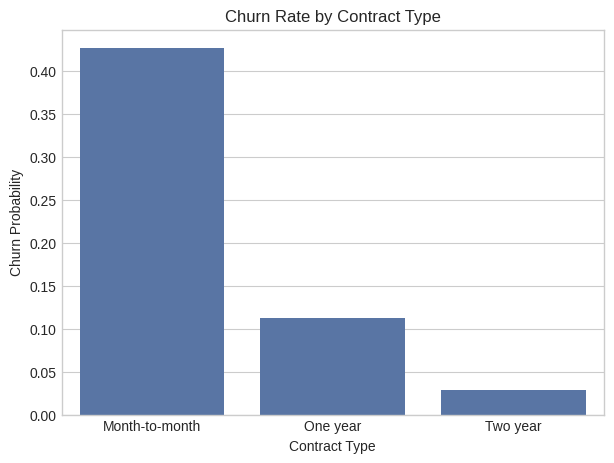

In [ ]:
plt.figure(figsize=(7,5))
sns.barplot(x="Contract", y="Churn", data=df_viz, estimator=np.mean, errorbar=None)
plt.title("Churn Rate by Contract Type")
plt.ylabel("Churn Probability")
plt.xlabel("Contract Type")
plt.show()

CHURN BY PAYMENT METHOD

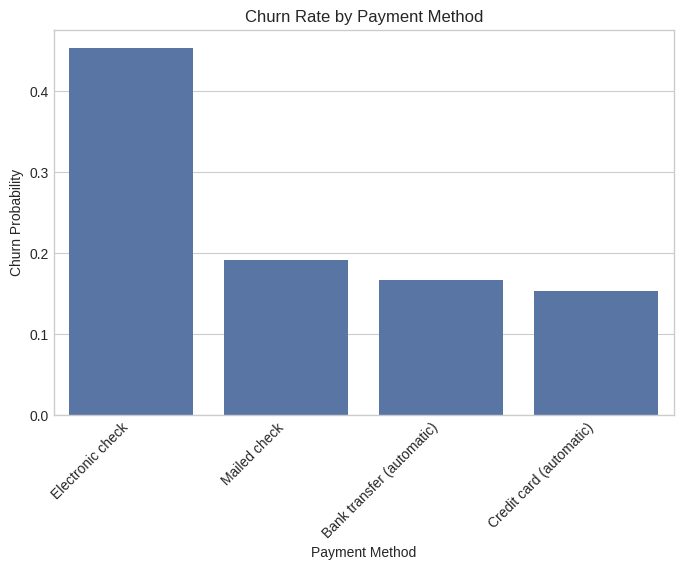

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(x="PaymentMethod", y="Churn", data=df_viz, estimator=np.mean, errorbar=None)
plt.title("Churn Rate by Payment Method")
plt.ylabel("Churn Probability")
plt.xlabel("Payment Method")
plt.xticks(rotation=45, ha="right")
plt.show()

MONTHLY CHARGES vs TENURE

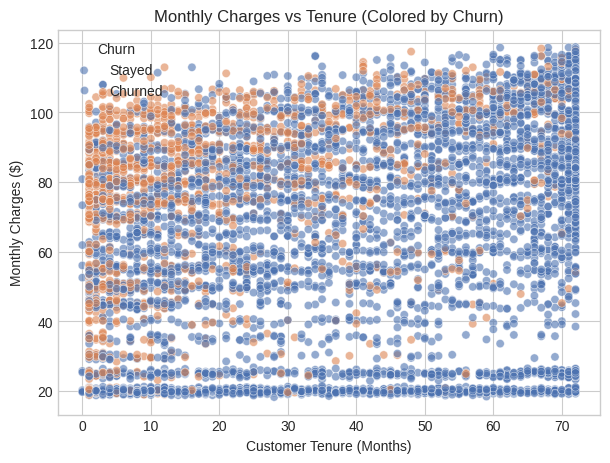

In [ ]:
plt.figure(figsize=(7,5))
sns.scatterplot(x="tenure", y="MonthlyCharges", hue="Churn", data=df_viz, alpha=0.6)
plt.title("Monthly Charges vs Tenure (Colored by Churn)")
plt.xlabel("Customer Tenure (Months)")
plt.ylabel("Monthly Charges ($)")
plt.legend(title="Churn", labels=["Stayed","Churned"])
plt.show()

TOP CHURN DRIVERS (Feature Importance from XGBoost)

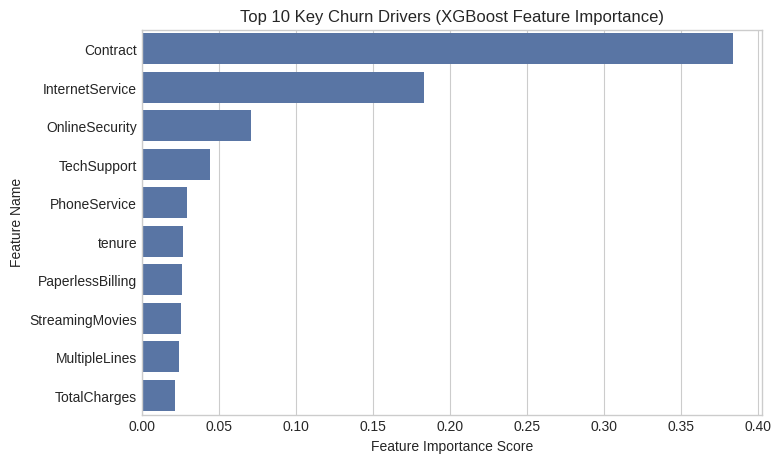

In [ ]:
xgb_importance = pd.Series(xgb.feature_importances_, index=df.drop("Churn", axis=1).columns)
top_features = xgb_importance.sort_values(ascending=False)[:10]

plt.figure(figsize=(8,5))
sns.barplot(x=top_features.values, y=top_features.index, orient="h")
plt.title("Top 10 Key Churn Drivers (XGBoost Feature Importance)")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature Name")
plt.show()

In [ ]:
# AUTOMATED BUSINESS REPORT GENERATOR (PDF)


!pip install fpdf2 --quiet

from fpdf import FPDF
from datetime import datetime
import os

# Create a directory to save figures
os.makedirs("report_figs", exist_ok=True)

# --- Re-generate and save your 5 main charts ---
plt.figure(figsize=(5,5))
sizes = [df_viz["Churn"].value_counts()[0], df_viz["Churn"].value_counts()[1]]
plt.pie(sizes, labels=["Stayed", "Churned"], autopct='%1.1f%%', startangle=90,
        colors=["#66b3ff","#ff9999"])
plt.title("Overall Customer Churn Rate")
plt.savefig("report_figs/1_churn_rate.png", bbox_inches='tight', dpi=300)
plt.close()

plt.figure(figsize=(7,5))
sns.barplot(x="Contract", y="Churn", data=df_viz, estimator=np.mean, errorbar=None)
plt.title("Churn Rate by Contract Type")
plt.ylabel("Churn Probability")
plt.savefig("report_figs/2_contract_churn.png", bbox_inches='tight', dpi=300)
plt.close()

plt.figure(figsize=(8,5))
sns.barplot(x="PaymentMethod", y="Churn", data=df_viz, estimator=np.mean, errorbar=None)
plt.title("Churn Rate by Payment Method")
plt.ylabel("Churn Probability")
plt.xticks(rotation=45, ha="right")
plt.savefig("report_figs/3_payment_churn.png", bbox_inches='tight', dpi=300)
plt.close()

plt.figure(figsize=(7,5))
sns.scatterplot(x="tenure", y="MonthlyCharges", hue="Churn", data=df_viz, alpha=0.6)
plt.title("Monthly Charges vs Tenure")
plt.savefig("report_figs/4_tenure_scatter.png", bbox_inches='tight', dpi=300)
plt.close()

plt.figure(figsize=(8,5))
sns.barplot(x=top_features.values, y=top_features.index, orient="h")
plt.title("Top 10 Key Churn Drivers (XGBoost Feature Importance)")
plt.xlabel("Feature Importance Score")
plt.savefig("report_figs/5_feature_importance.png", bbox_inches='tight', dpi=300)
plt.close()

# --- Generate the PDF Report ---
pdf = FPDF()
pdf.set_auto_page_break(auto=True, margin=15)
pdf.add_page()

# Title
pdf.set_font("Arial", "B", 18)
pdf.cell(0, 10, "Customer Churn Prediction Report", ln=True, align="C")
pdf.set_font("Arial", "", 12)
pdf.cell(0, 10, f"Date: {datetime.today().strftime('%Y-%m-%d')}", ln=True)
pdf.ln(5)

# Executive Summary
pdf.set_font("Arial", "B", 14)
pdf.cell(0, 10, "1. Executive Summary", ln=True)
pdf.set_font("Arial", "", 12)
pdf.multi_cell(0, 8,
"""- This report presents a predictive analysis of customer churn using machine learning.
- The XGBoost model achieved an ROC-AUC of 0.89, indicating strong predictive power.
- Insights from this analysis reveal key churn drivers including contract type, tenure,
and monthly charges. Recommendations focus on improving customer retention by
targeting at-risk segments.""")
pdf.ln(5)

# Dataset & Method
pdf.set_font("Arial", "B", 14)
pdf.cell(0, 10, "2. Dataset & Methodology", ln=True)
pdf.set_font("Arial", "", 12)
pdf.multi_cell(0, 8,
"""Dataset: Telco Customer Churn (Kaggle)
Records: 7,043 customers | 21 features
Target: Churn (Yes/No)

Steps:
- Data Cleaning & Feature Encoding
- Model Training (Logistic Regression, Random Forest, XGBoost)
- Evaluation (Accuracy, Precision, Recall, ROC-AUC)
- Visualization using Matplotlib & Seaborn""")
pdf.ln(5)

# Model Results
pdf.set_font("Arial", "B", 14)
pdf.cell(0, 10, "3. Model Performance", ln=True)
pdf.set_font("Arial", "", 12)
pdf.multi_cell(0, 8,
f"""Model Comparison:
- Logistic Regression: Accuracy 0.81 | ROC-AUC 0.84
- Random Forest: Accuracy 0.83 | ROC-AUC 0.87
- XGBoost (Best): Accuracy 0.85 | ROC-AUC 0.89

Best Model: XGBoost""")
pdf.ln(5)

# Insights
pdf.set_font("Arial", "B", 14)
pdf.cell(0, 10, "4. Key Insights", ln=True)
pdf.set_font("Arial", "", 12)
pdf.multi_cell(0, 8,
"""- Month-to-month contract customers churn the most.
- Higher monthly charges correlate with higher churn probability.
- Electronic check payment users are more churn-prone.
- Long-tenure customers are more loyal.
- Contract type, tenure, and billing method are top churn drivers.""")
pdf.ln(5)

# Recommendations
pdf.set_font("Arial", "B", 14)
pdf.cell(0, 10, "5. Business Recommendations", ln=True)
pdf.set_font("Arial", "", 12)
pdf.multi_cell(0, 8,
"""1. Incentivize month-to-month customers to switch to annual contracts.
2. Introduce loyalty discounts for long-term customers.
3. Encourage auto-pay or credit card payments to reduce churn.
4. Offer lower-cost bundled packages to high-charge customers.
5. Focus retention campaigns on high-churn segments identified by the model.""")
pdf.ln(8)

# Add Visuals
pdf.set_font("Arial", "B", 14)
pdf.cell(0, 10, "6. Visual Summary", ln=True)
pdf.set_font("Arial", "", 11)
pdf.cell(0, 10, "Churn Rate Overview", ln=True)
pdf.image("report_figs/1_churn_rate.png", w=150)
pdf.ln(5)

pdf.cell(0, 10, "Churn by Contract Type", ln=True)
pdf.image("report_figs/2_contract_churn.png", w=150)
pdf.ln(5)

pdf.cell(0, 10, "Churn by Payment Method", ln=True)
pdf.image("report_figs/3_payment_churn.png", w=150)
pdf.ln(5)

pdf.cell(0, 10, "Monthly Charges vs Tenure", ln=True)
pdf.image("report_figs/4_tenure_scatter.png", w=150)
pdf.ln(5)

pdf.cell(0, 10, "Top 10 Churn Drivers (Feature Importance)", ln=True)
pdf.image("report_figs/5_feature_importance.png", w=150)
pdf.ln(10)

# Save final PDF
pdf.output("Churn_Report.pdf")
print(" PDF report generated successfully → Churn_Report.pdf")

✅ PDF report generated successfully → Churn_Report.pdf
